In [ ]:
import torch
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "straght_or_curly"

In [ ]:
import os

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

source_path = '/content/drive/MyDrive/DL/straight_or_curly.zip'
destination_path = '/content/data/straight_or_curly.zip'

if os.path.exists(destination_path):
    print("File already exists at the destination.")
else:
    # If not, copy the file
    !cp "{source_path}" "{destination_path}"
    print("File copied successfully.")

with zipfile.ZipFile(data_path / "straight_or_curly.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

Did not find data/straght_or_curly directory, creating one...
File copied successfully.


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
from torchvision import transforms
train_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),

    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=train_data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=test_data_transform)

In [ ]:
from torch.utils.data import DataLoader

# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader = DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ae65b60b400>,
 <torch.utils.data.dataloader.DataLoader at 0x7ae65b60b4c0>)

In [ ]:
class_names = train_data.classes
class_names

['curly', 'straight']

In [ ]:
img, label = train_data[0]

## Pretrained Weights

### ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V1
model_resnet50 = resnet50(weights=weights).to(device)
model_resnet50.fc = nn.Linear(in_features=2048, out_features=1).to(device)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X).squeeze(1)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.sigmoid(y_pred).round()
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X).squeeze(1).float()

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.sigmoid(test_pred_logits).round()
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc*100:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_resnet50.parameters(), lr=0.00001)

In [ ]:
model_resnet50_results = train(model_resnet50, train_dataloader, test_dataloader, optimizer, loss_fn, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5705 | train_acc: 77.8815 | test_loss: 0.4004 | test_acc: 96.1806
Epoch: 2 | train_loss: 0.2963 | train_acc: 93.4118 | test_loss: 0.2046 | test_acc: 96.8750
Epoch: 3 | train_loss: 0.1565 | train_acc: 96.7803 | test_loss: 0.1333 | test_acc: 97.2222
Epoch: 4 | train_loss: 0.1068 | train_acc: 97.9167 | test_loss: 0.1011 | test_acc: 97.2222
Epoch: 5 | train_loss: 0.0707 | train_acc: 98.8636 | test_loss: 0.0703 | test_acc: 97.9167


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

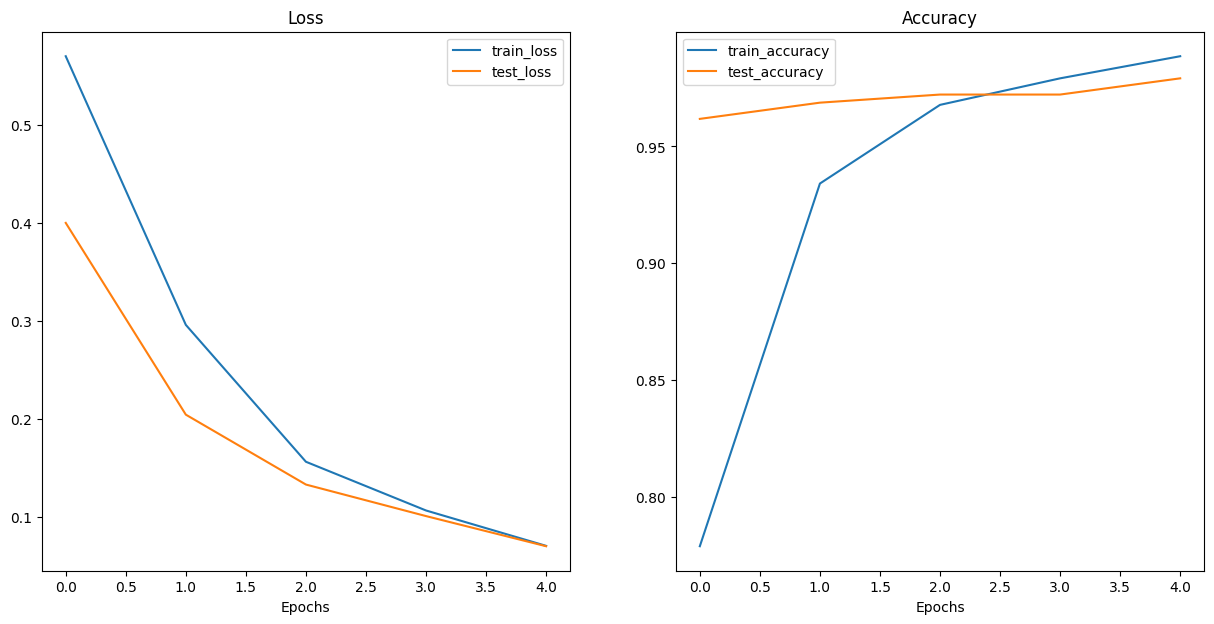

In [ ]:
plot_loss_curves(model_resnet50_results)

### DenseNet121

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights
weights = DenseNet121_Weights.IMAGENET1K_V1
model_densenet121 = densenet121(weights=weights).to(device)
model_densenet121.classifier = nn.Linear(in_features=1024, out_features=1).to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 164MB/s]


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_densenet121.parameters(), lr=0.00001)

In [ ]:
model_densenet121_results = train(model_densenet121, train_dataloader, test_dataloader, optimizer, loss_fn, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6000 | train_acc: 69.7376 | test_loss: 0.4800 | test_acc: 91.6667
Epoch: 2 | train_loss: 0.4248 | train_acc: 90.0568 | test_loss: 0.3419 | test_acc: 95.4861
Epoch: 3 | train_loss: 0.3105 | train_acc: 93.0736 | test_loss: 0.2466 | test_acc: 95.8333
Epoch: 4 | train_loss: 0.2455 | train_acc: 95.2110 | test_loss: 0.1890 | test_acc: 96.5278
Epoch: 5 | train_loss: 0.1847 | train_acc: 95.9686 | test_loss: 0.1610 | test_acc: 97.5694


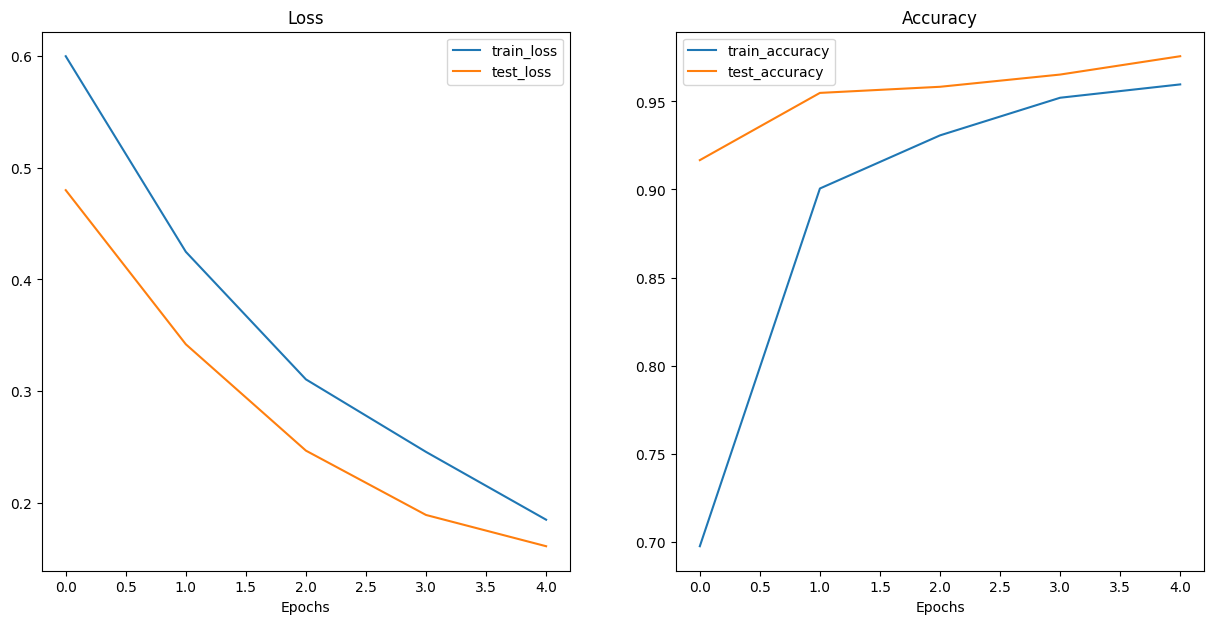

In [ ]:
plot_loss_curves(model_densenet121_results)

### ConvNeXt Base

In [ ]:
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model_convnext_base = convnext_base(weights=weights).to(device)
model_convnext_base.classifier[2] = nn.Linear(in_features=1024, out_features=1).to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_convnext_base.parameters(), lr=0.00001)

In [ ]:
model_convnext_base_results = train(model_convnext_base, train_dataloader, test_dataloader, optimizer, loss_fn, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6370 | train_acc: 65.9497 | test_loss: 0.5653 | test_acc: 77.0833
Epoch: 2 | train_loss: 0.4428 | train_acc: 89.3939 | test_loss: 0.3820 | test_acc: 87.8472
Epoch: 3 | train_loss: 0.2670 | train_acc: 95.5492 | test_loss: 0.2120 | test_acc: 96.8750
Epoch: 4 | train_loss: 0.1646 | train_acc: 96.7262 | test_loss: 0.1463 | test_acc: 97.2222
Epoch: 5 | train_loss: 0.1088 | train_acc: 97.6732 | test_loss: 0.1207 | test_acc: 96.5278


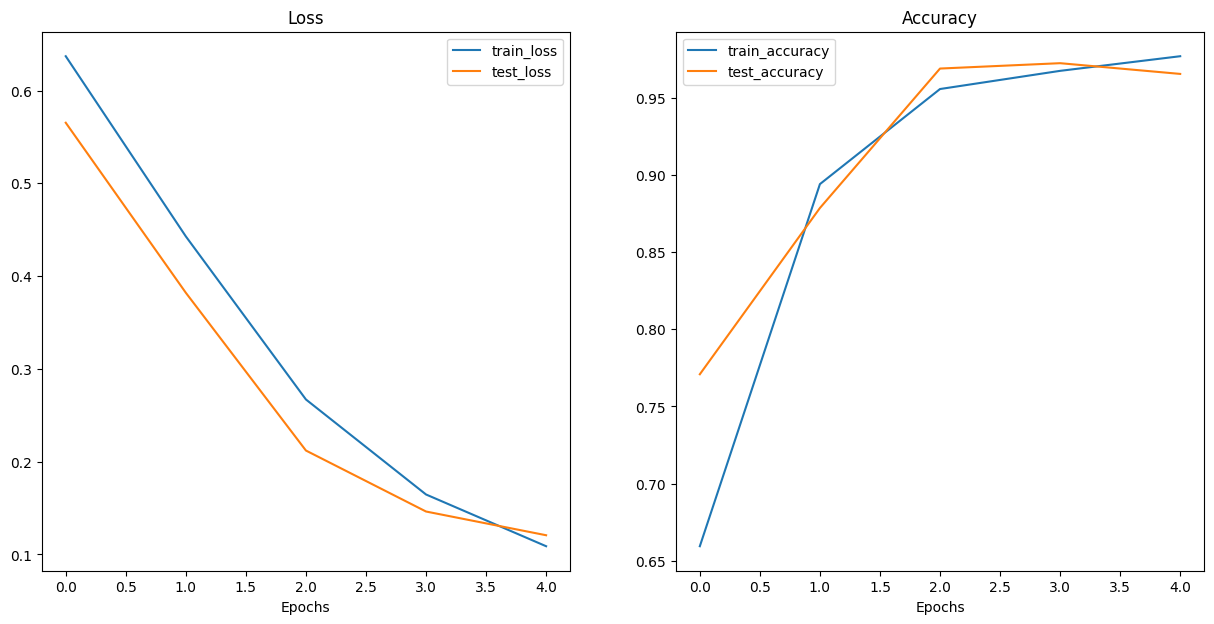

In [ ]:
plot_loss_curves(model_convnext_base_results)

## Non Pretrained

### ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
model_resnet50 = resnet50().to(device)
model_resnet50.fc = nn.Linear(in_features=2048, out_features=1).to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_resnet50.parameters(), lr=0.00001)

In [ ]:
model_resnet50_results = train(model_resnet50, train_dataloader, test_dataloader, optimizer, loss_fn, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6880 | train_acc: 54.1396 | test_loss: 0.6904 | test_acc: 56.9444
Epoch: 2 | train_loss: 0.6706 | train_acc: 58.4551 | test_loss: 0.6735 | test_acc: 56.2500
Epoch: 3 | train_loss: 0.6644 | train_acc: 61.5395 | test_loss: 0.6552 | test_acc: 61.4583
Epoch: 4 | train_loss: 0.6547 | train_acc: 60.6196 | test_loss: 0.6451 | test_acc: 60.4167
Epoch: 5 | train_loss: 0.6458 | train_acc: 64.6239 | test_loss: 0.6352 | test_acc: 66.3194
Epoch: 6 | train_loss: 0.6362 | train_acc: 67.1672 | test_loss: 0.6064 | test_acc: 68.0556
Epoch: 7 | train_loss: 0.6255 | train_acc: 65.2327 | test_loss: 0.5923 | test_acc: 66.3194
Epoch: 8 | train_loss: 0.6118 | train_acc: 67.9789 | test_loss: 0.5636 | test_acc: 73.9583
Epoch: 9 | train_loss: 0.6048 | train_acc: 68.4930 | test_loss: 0.5434 | test_acc: 71.5278
Epoch: 10 | train_loss: 0.5827 | train_acc: 70.9145 | test_loss: 0.5310 | test_acc: 73.6111
Epoch: 11 | train_loss: 0.5525 | train_acc: 73.8501 | test_loss: 0.5538 | test_acc: 71.18

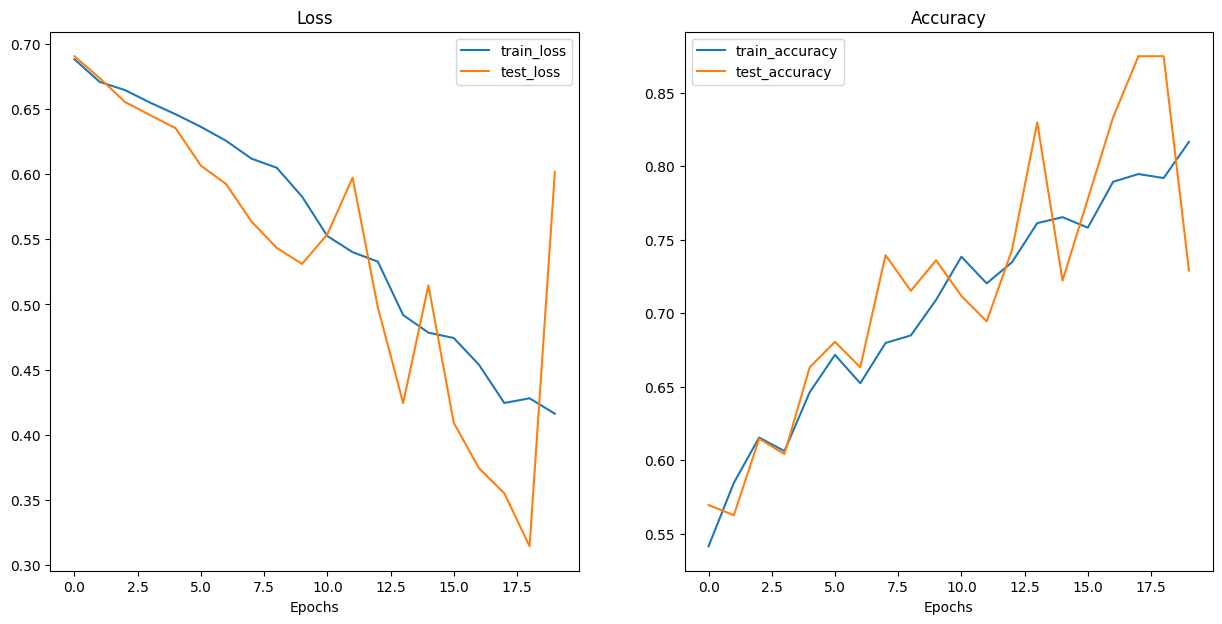

In [ ]:
plot_loss_curves(model_resnet50_results)

### DenseNet121

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights
model_densenet121 = densenet121().to(device)
model_densenet121.classifier = nn.Linear(in_features=1024, out_features=1).to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_densenet121.parameters(), lr=0.00001)

In [ ]:
model_densenet121_results = train(model_densenet121, train_dataloader, test_dataloader, optimizer, loss_fn, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6796 | train_acc: 54.1802 | test_loss: 0.6590 | test_acc: 56.5972
Epoch: 2 | train_loss: 0.6426 | train_acc: 65.3274 | test_loss: 0.6157 | test_acc: 69.7917
Epoch: 3 | train_loss: 0.6189 | train_acc: 66.5043 | test_loss: 0.5907 | test_acc: 72.2222
Epoch: 4 | train_loss: 0.5990 | train_acc: 69.3047 | test_loss: 0.5583 | test_acc: 73.9583
Epoch: 5 | train_loss: 0.5705 | train_acc: 71.5368 | test_loss: 0.5330 | test_acc: 75.0000
Epoch: 6 | train_loss: 0.5433 | train_acc: 73.8636 | test_loss: 0.4952 | test_acc: 77.0833
Epoch: 7 | train_loss: 0.5143 | train_acc: 75.9876 | test_loss: 0.4631 | test_acc: 78.1250
Epoch: 8 | train_loss: 0.5051 | train_acc: 75.7982 | test_loss: 0.4294 | test_acc: 84.7222
Epoch: 9 | train_loss: 0.4770 | train_acc: 78.7338 | test_loss: 0.3969 | test_acc: 86.1111
Epoch: 10 | train_loss: 0.4540 | train_acc: 80.1001 | test_loss: 0.3670 | test_acc: 86.8056
Epoch: 11 | train_loss: 0.4470 | train_acc: 80.1813 | test_loss: 0.3455 | test_acc: 89.58

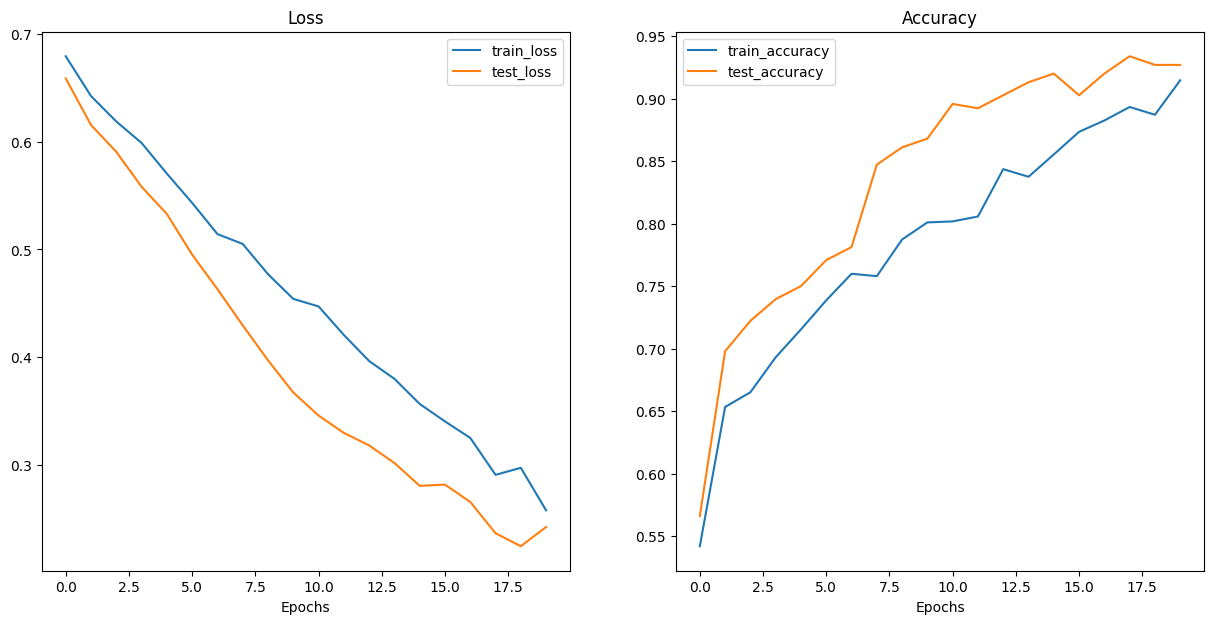

In [ ]:
plot_loss_curves(model_densenet121_results)

### ConvNeXt Base

In [ ]:
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
model_convnext_base = convnext_base().to(device)
model_convnext_base.classifier[2] = nn.Linear(in_features=1024, out_features=1).to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_convnext_base.parameters(), lr=0.00001)

In [ ]:
model_convnext_base_results = train(model_convnext_base, train_dataloader, test_dataloader, optimizer, loss_fn, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6957 | train_acc: 52.3539 | test_loss: 0.6908 | test_acc: 55.5556
Epoch: 2 | train_loss: 0.7083 | train_acc: 50.2706 | test_loss: 0.6832 | test_acc: 58.3333
Epoch: 3 | train_loss: 0.6998 | train_acc: 50.4329 | test_loss: 0.6815 | test_acc: 57.9861
Epoch: 4 | train_loss: 0.7038 | train_acc: 50.6494 | test_loss: 0.6815 | test_acc: 58.3333
Epoch: 5 | train_loss: 0.6921 | train_acc: 52.7733 | test_loss: 0.6779 | test_acc: 59.7222
Epoch: 6 | train_loss: 0.7012 | train_acc: 50.4600 | test_loss: 0.7084 | test_acc: 43.0556
Epoch: 7 | train_loss: 0.6991 | train_acc: 50.5005 | test_loss: 0.6807 | test_acc: 59.3750
Epoch: 8 | train_loss: 0.6981 | train_acc: 51.8398 | test_loss: 0.6881 | test_acc: 55.2083
Epoch: 9 | train_loss: 0.6943 | train_acc: 51.1634 | test_loss: 0.6773 | test_acc: 59.7222
Epoch: 10 | train_loss: 0.6936 | train_acc: 53.2062 | test_loss: 0.6758 | test_acc: 59.3750
Epoch: 11 | train_loss: 0.6920 | train_acc: 51.4746 | test_loss: 0.6831 | test_acc: 54.86

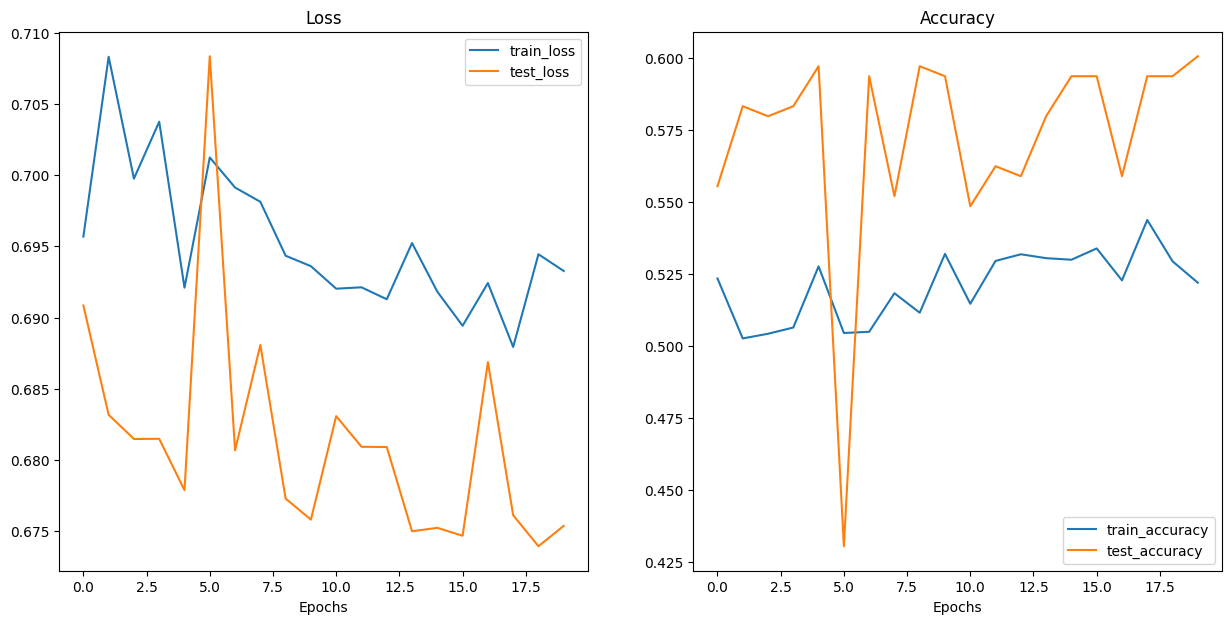

In [ ]:
plot_loss_curves(model_convnext_base_results)

## Inferencing

In [ ]:
import torchvision
def pred_and_plot_images(models, model_names, image_path, class_names, transform=None, device=device):
    """Makes predictions on a target image using multiple models and plots them side by side."""

    import matplotlib.pyplot as plt

    # Load and preprocess the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.  # Normalize to [0, 1]

    # Apply transformations if provided
    if transform:
        target_image = transform(target_image)

    # Add an extra dimension for batch size
    target_image = target_image.unsqueeze(dim=0).to(device)

    # Create a figure for side-by-side plotting
    fig, axs = plt.subplots(1, len(models), figsize=(15, 5))

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        # Set model to evaluation mode and inference mode
        model.to(device)
        model.eval()
        with torch.inference_mode():
            # Make a prediction
            pred_logits = model(target_image)
            pred_probs = torch.sigmoid(pred_logits)
            pred_label = int(torch.round(pred_probs).squeeze(0))

        # Plot the image and its prediction
        axs[i].imshow(target_image.squeeze().cpu().permute(1, 2, 0))  # Ensure image format is correct
        if class_names:
            axs[i].set_title(f"{model_name}\nPred: {class_names[pred_label]}")
        else:
            axs[i].set_title(f"{model_name}\nPred: {pred_label}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

In [ ]:
def plot(predict_img_path):
  models = [model_resnet50, model_densenet121, model_convnext_base]
  model_names = ["ResNet50", "DenseNet121", "ConvNeXt Base"]

  pred_and_plot_images(models, model_names, predict_img_path, class_names, custom_image_transform)

### Pretrained

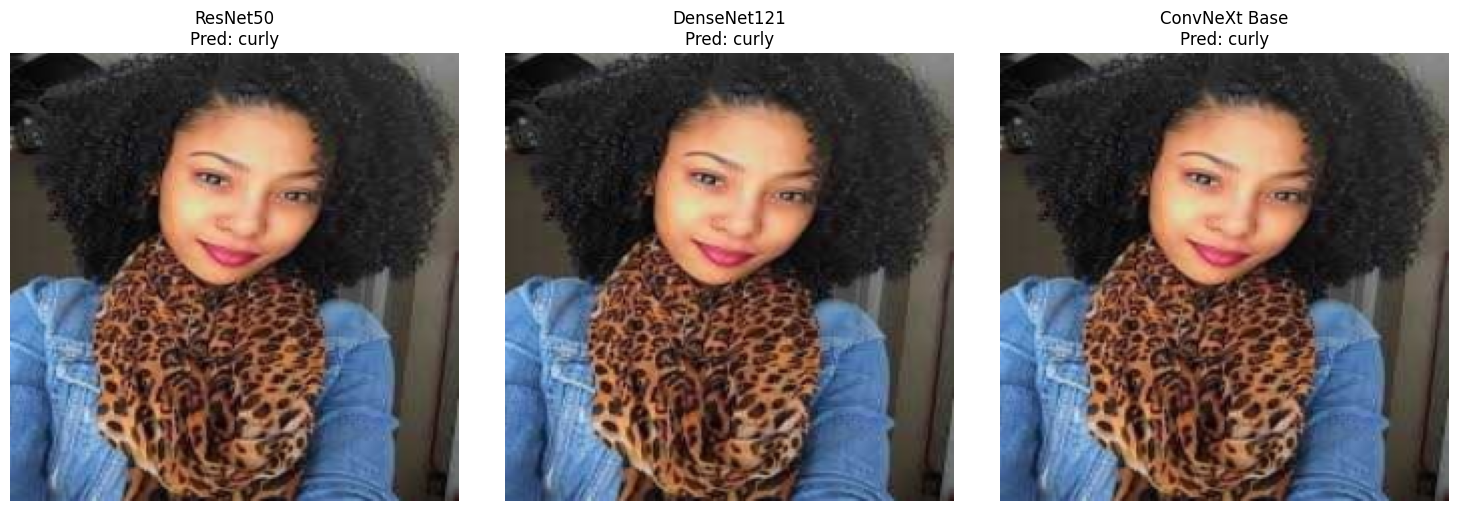

In [ ]:
predict_img_path = data_path / "1.jpg"
plot(predict_img_path)

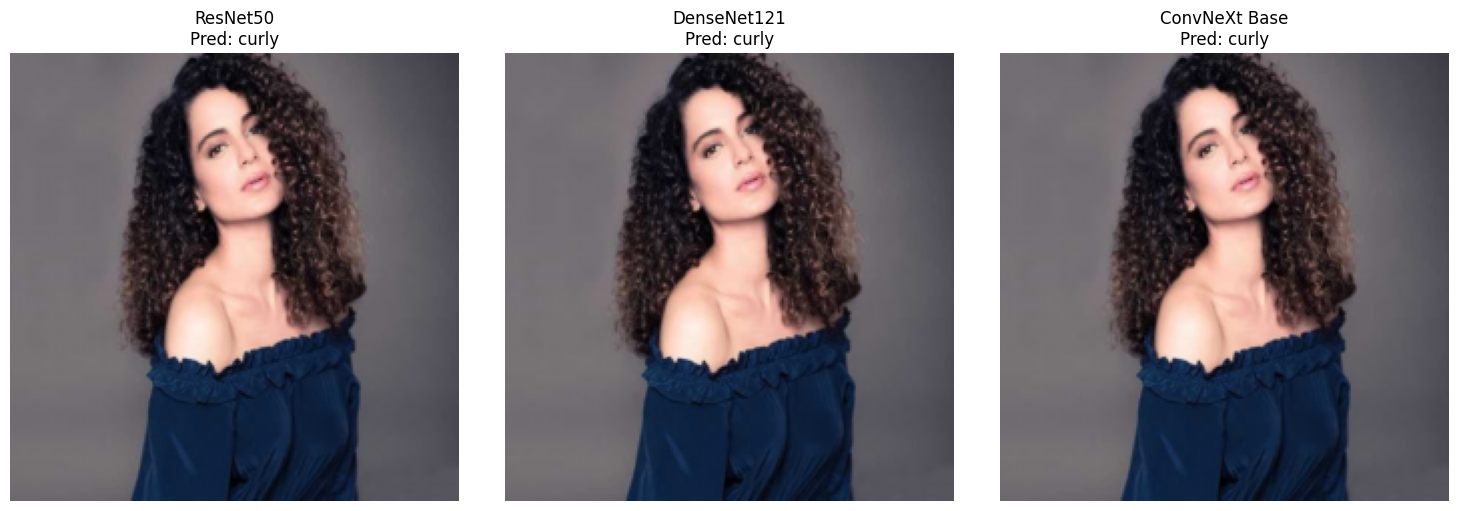

In [ ]:
predict_img_path = data_path / "2.jpg"
plot(predict_img_path)

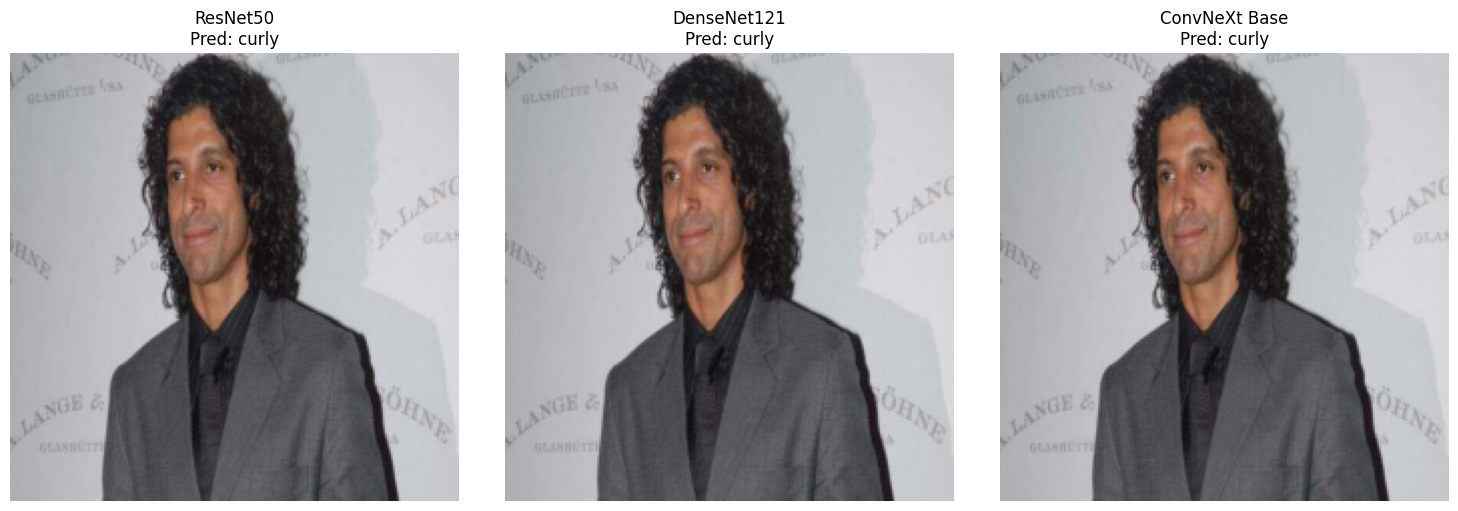

In [ ]:
predict_img_path = data_path / "3.jpg"
plot(predict_img_path)

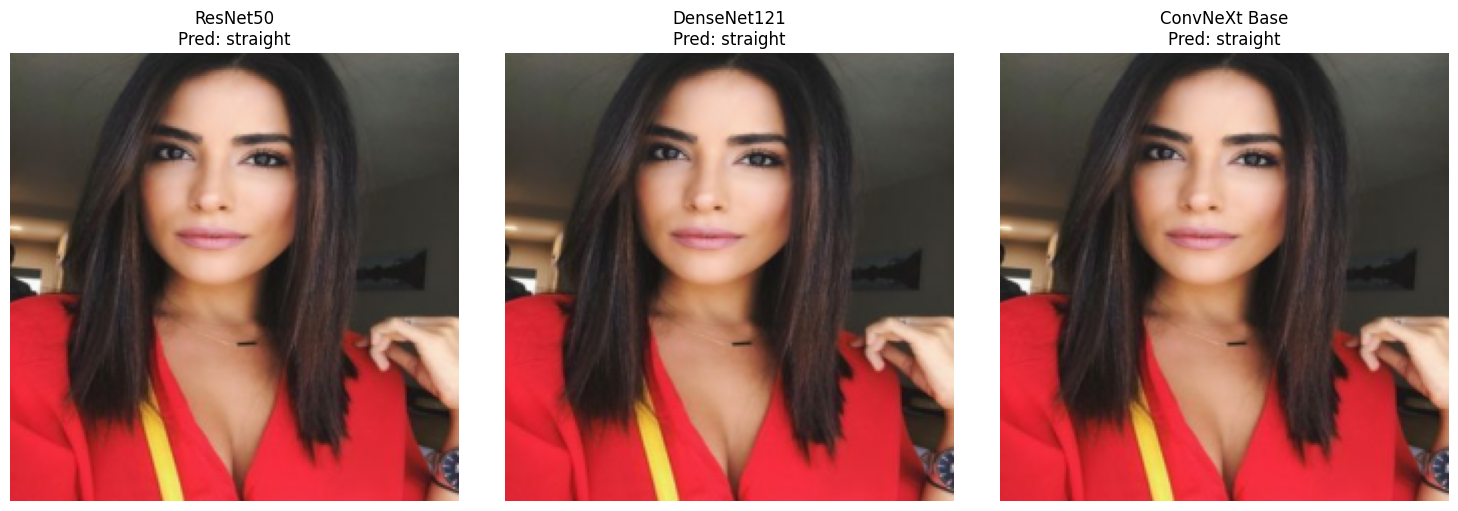

In [ ]:
predict_img_path = data_path / "4.jpg"
plot(predict_img_path)

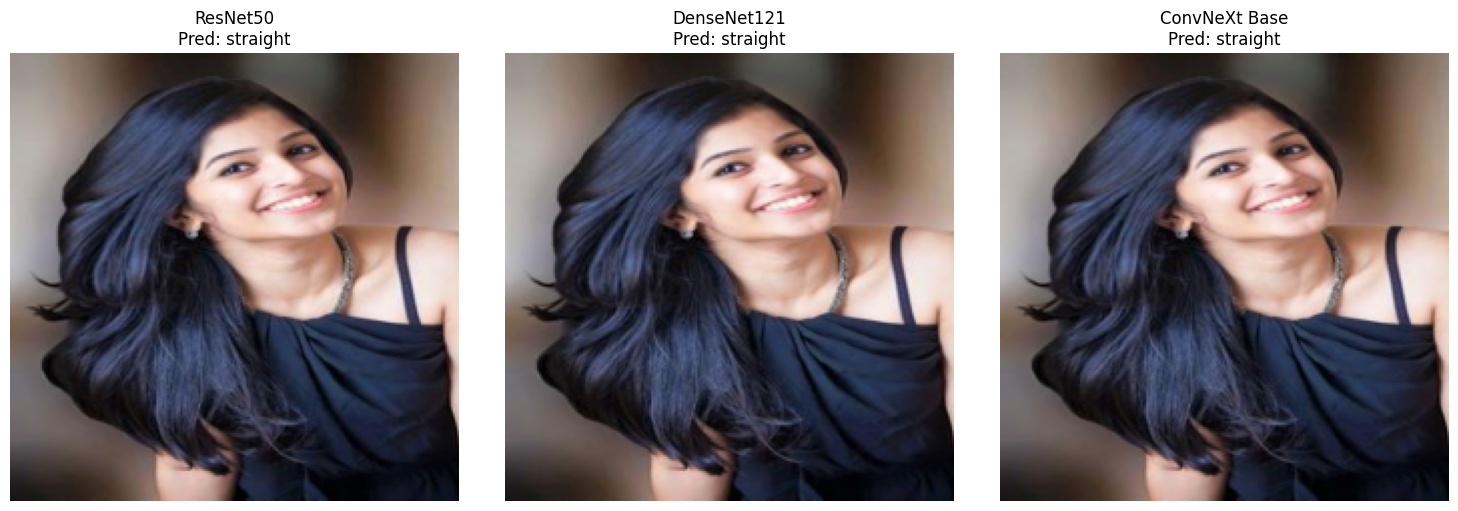

In [ ]:
predict_img_path = data_path / "5.jpg"
plot(predict_img_path)

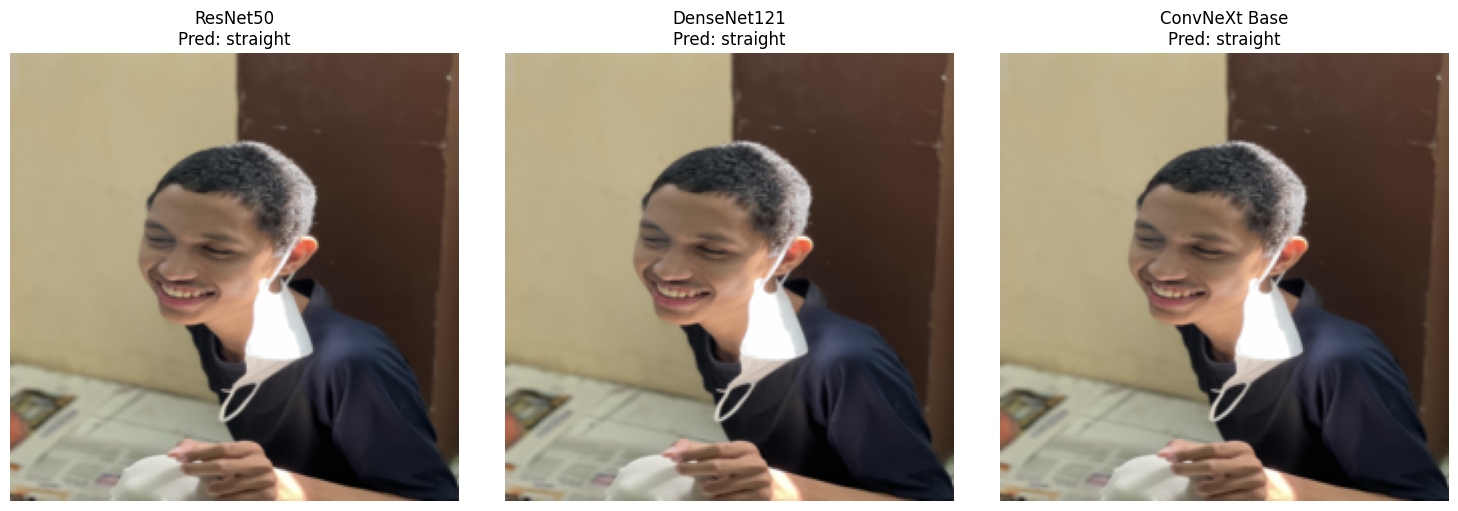

In [ ]:
predict_img_path = data_path / "6.jpg"
plot(predict_img_path)

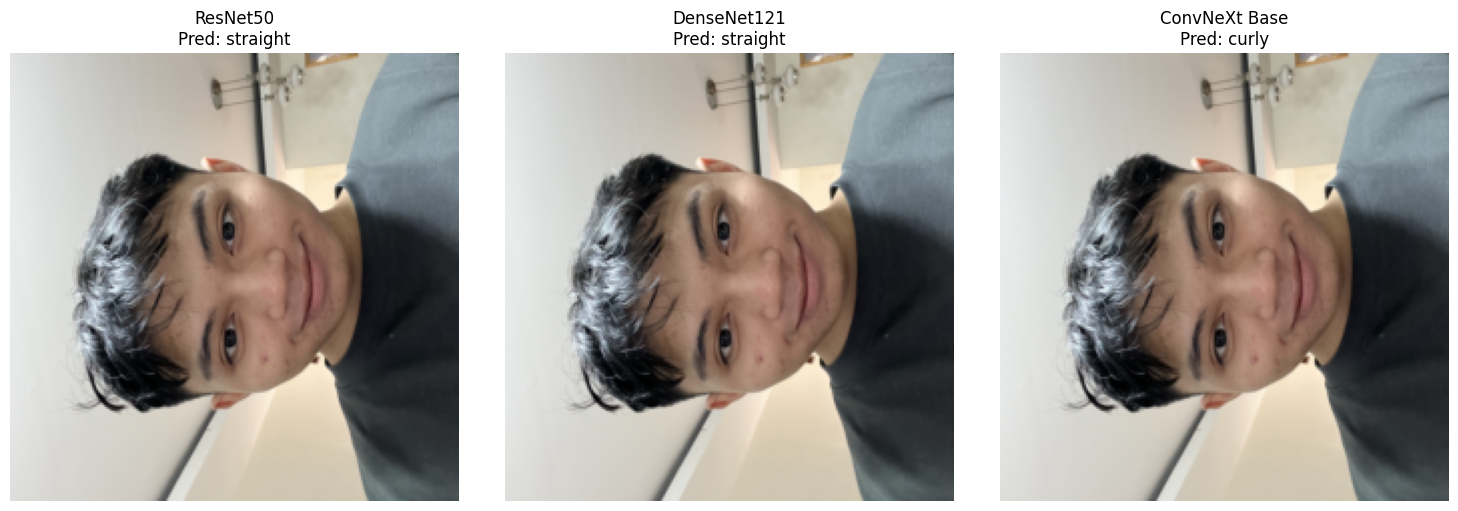

In [ ]:
predict_img_path = data_path / "7.jpg"
plot(predict_img_path)

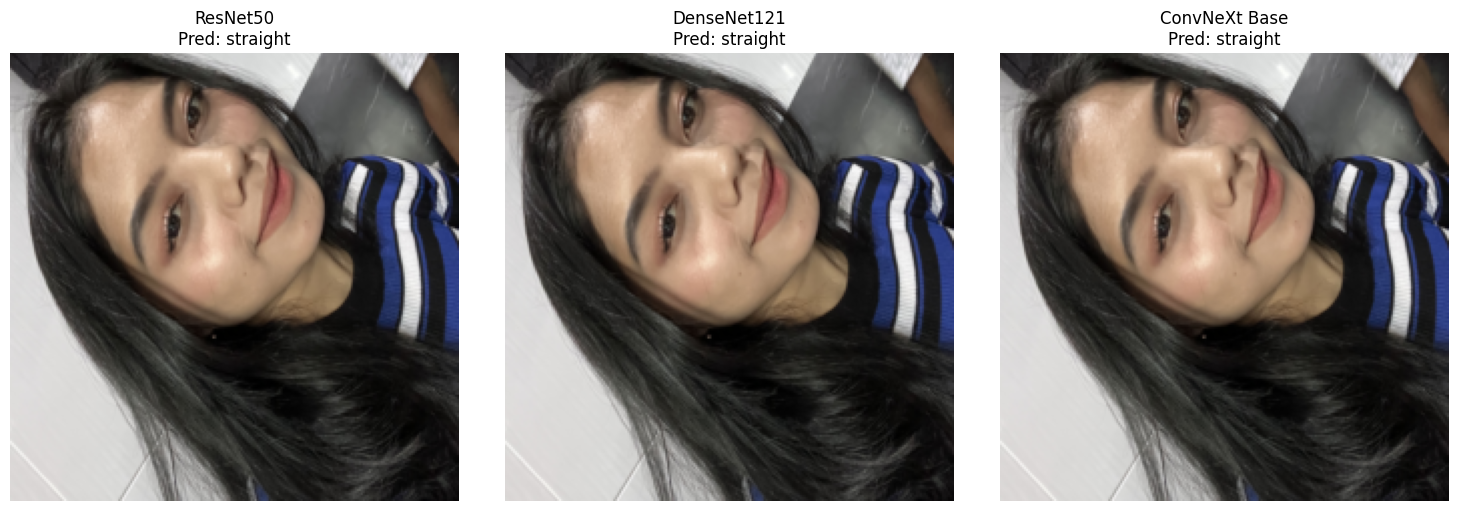

In [ ]:
predict_img_path = data_path / "8.jpg"
plot(predict_img_path)

### Non pretrained

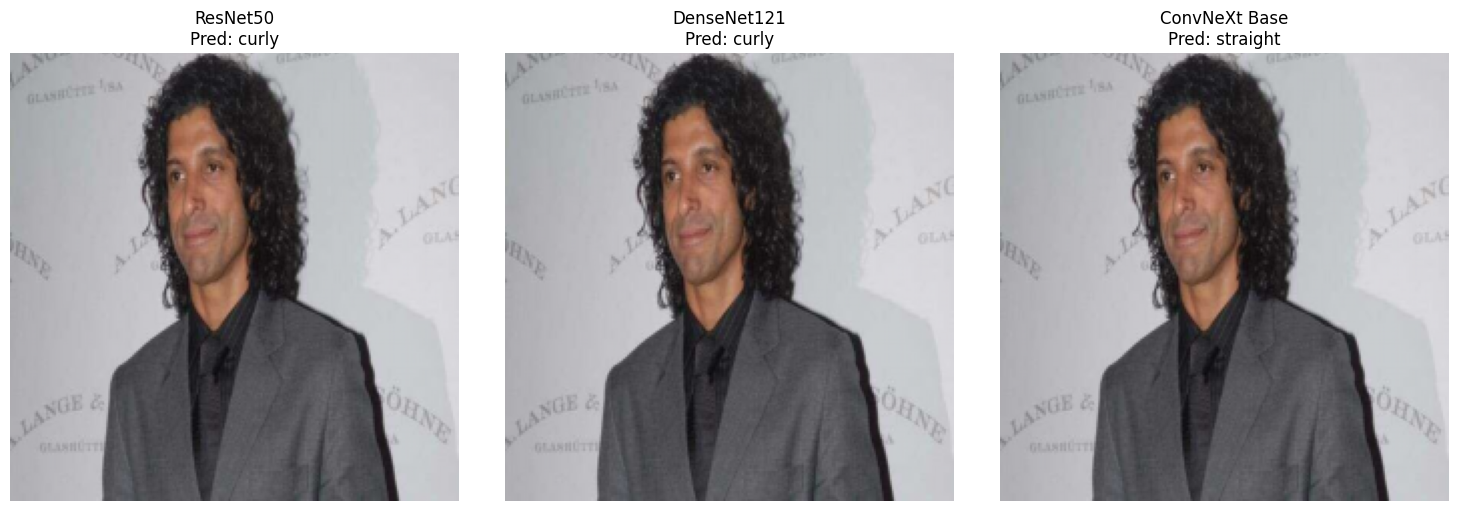

In [ ]:
predict_img_path = data_path / "1.jpg"
plot(predict_img_path)

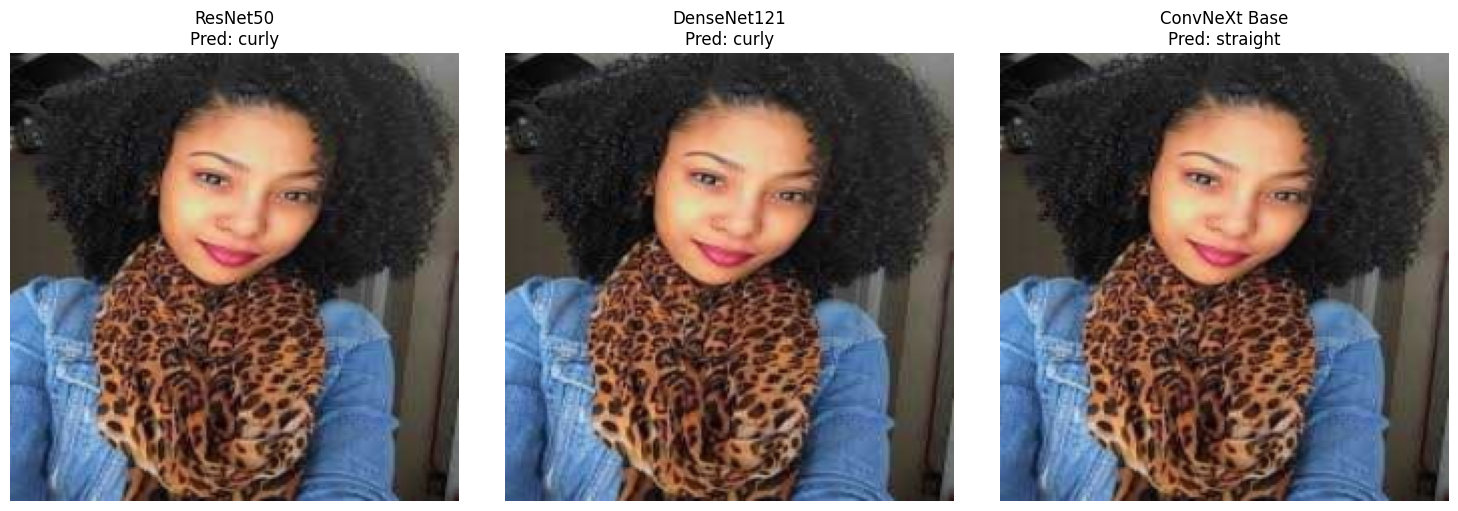

In [ ]:
predict_img_path = data_path / "2.jpg"
plot(predict_img_path)

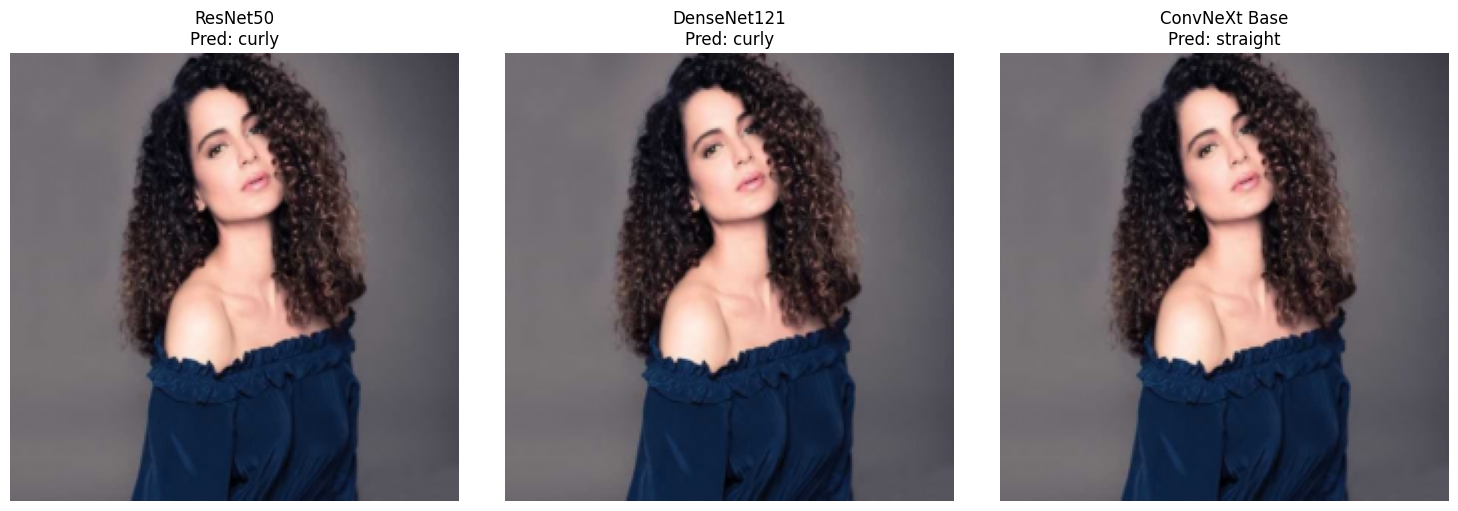

In [ ]:
predict_img_path = data_path / "3.jpg"
plot(predict_img_path)

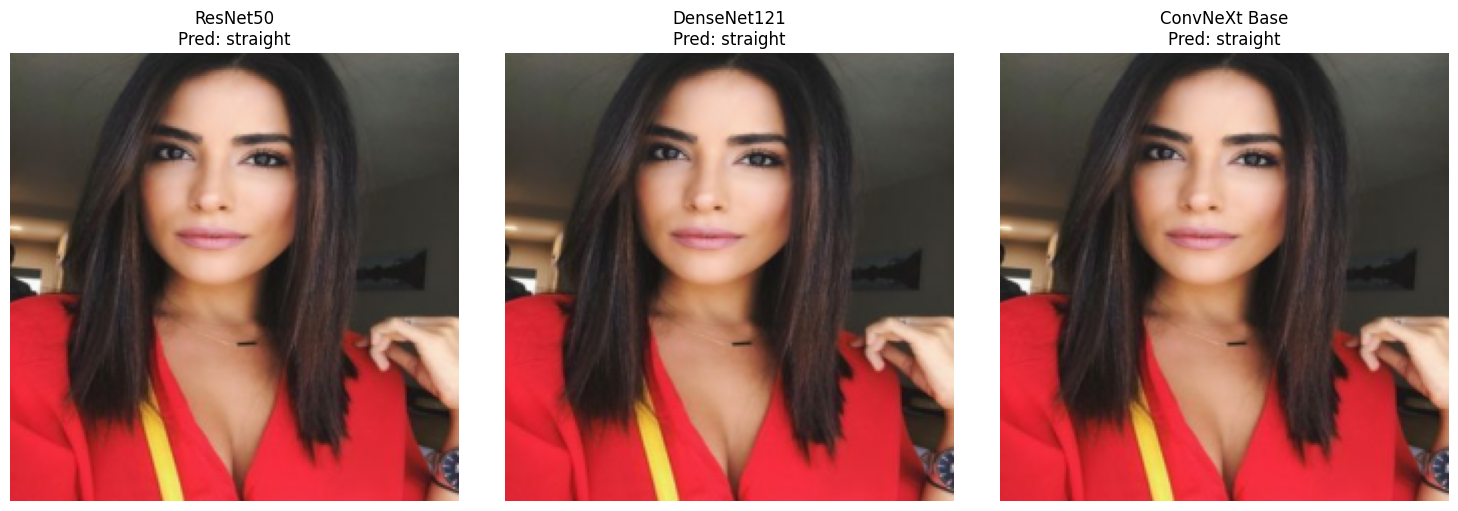

In [ ]:
predict_img_path = data_path / "4.jpg"
plot(predict_img_path)

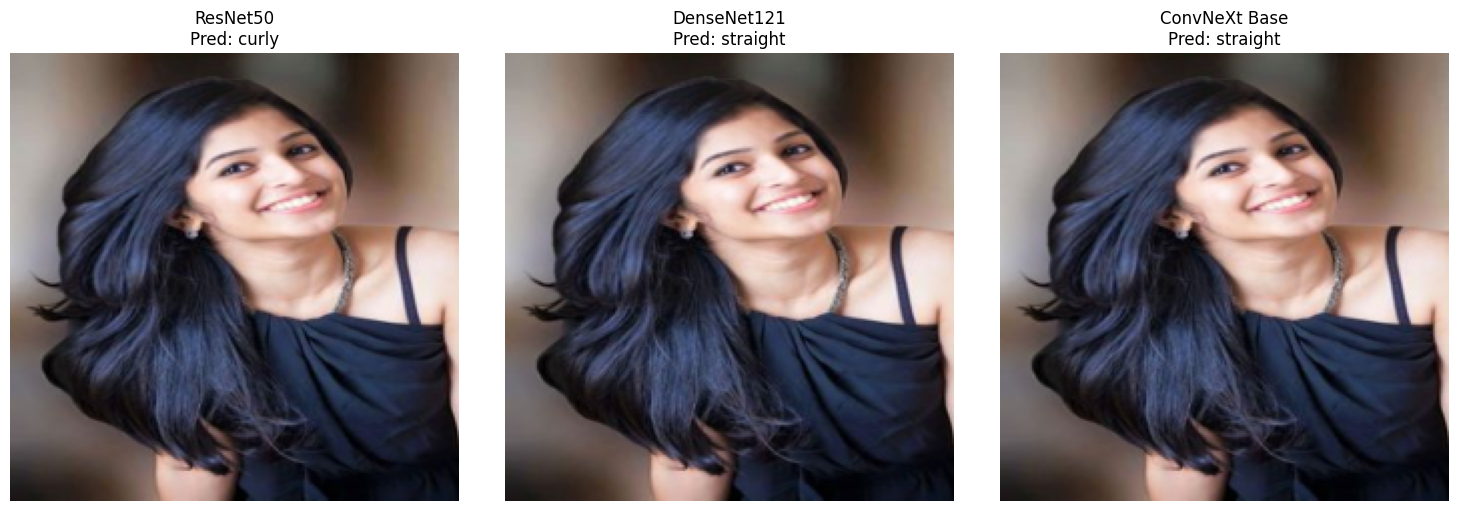

In [ ]:
predict_img_path = data_path / "5.jpg"
plot(predict_img_path)

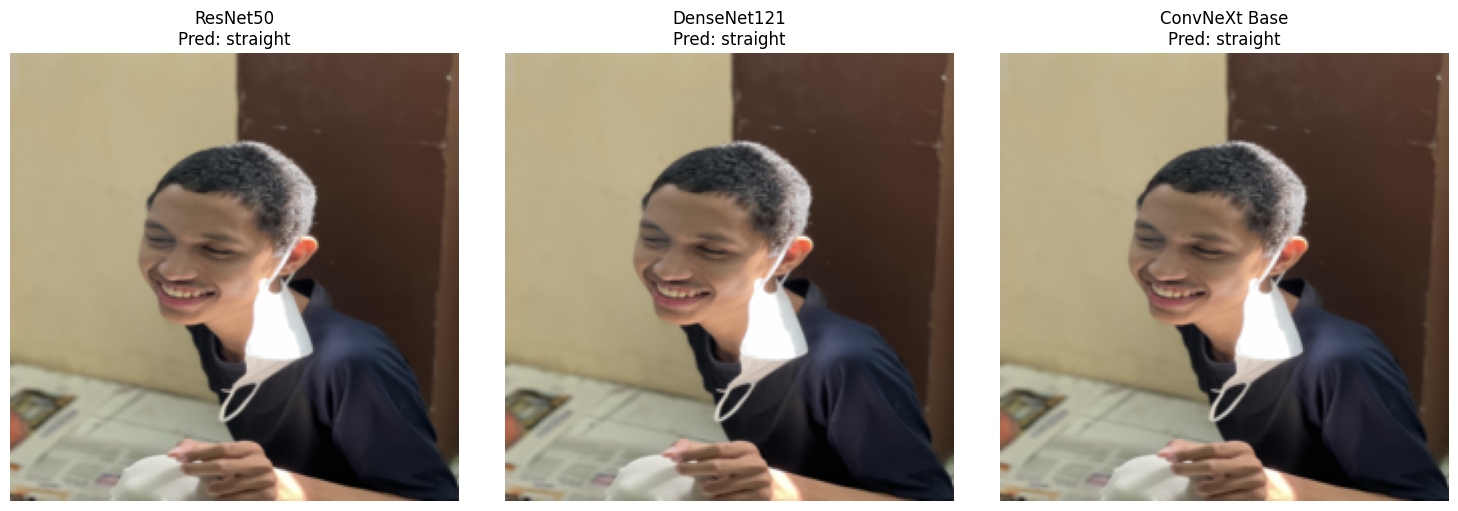

In [ ]:
predict_img_path = data_path / "6.jpg"
plot(predict_img_path)

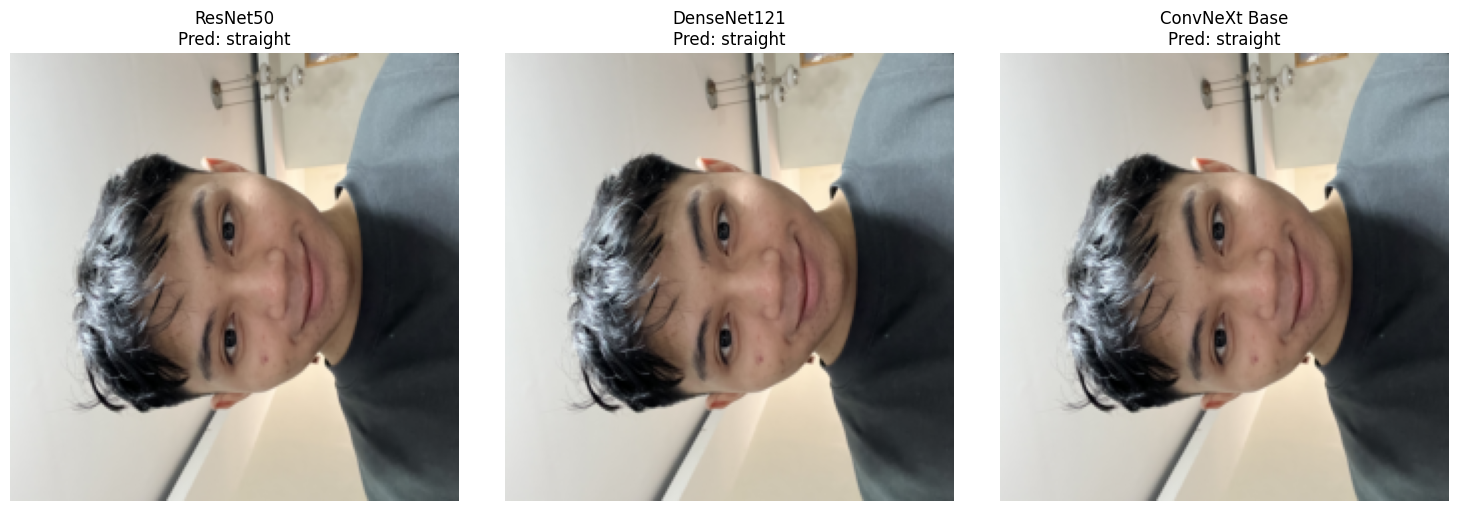

In [ ]:
predict_img_path = data_path / "7.jpg"
plot(predict_img_path)

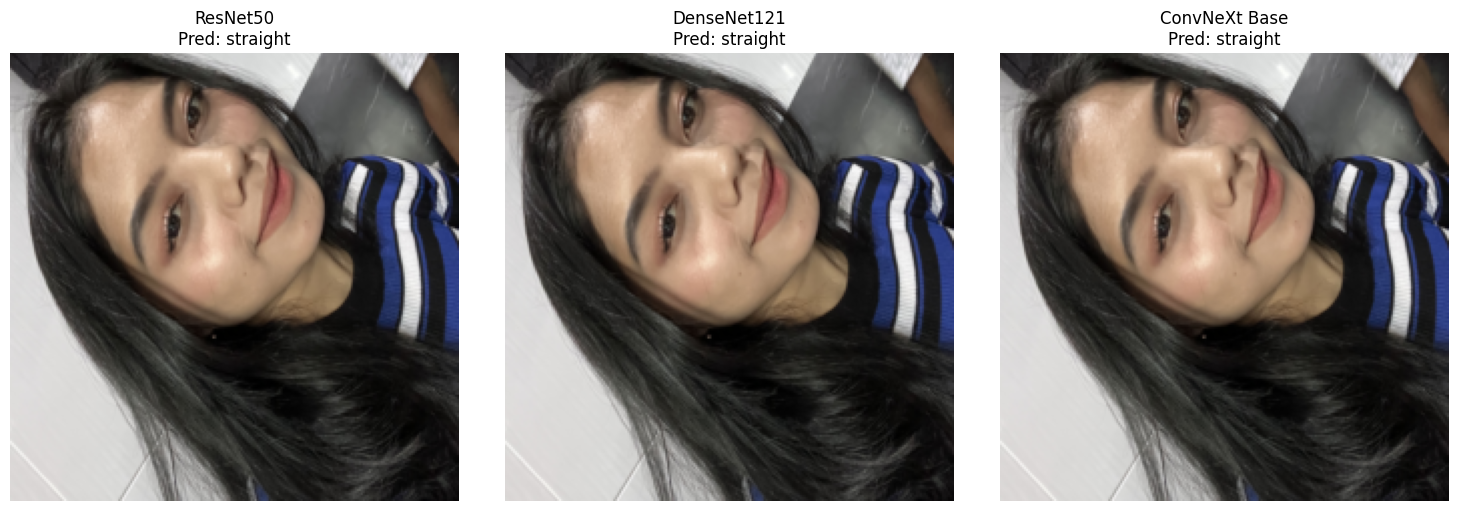

In [ ]:
predict_img_path = data_path / "8.jpg"
plot(predict_img_path)

## Save trained models

### Pretrained

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)  # Create parent directories if needed

# List of models and their names
models = [model_resnet50, model_densenet121, model_convnext_base]
model_names = ["resnet50_straight_or_not.pth", "densenet121_straight_or_not.pth", "convnext_base_straight_or_not.pth"]

# Save each model
for model, model_name in zip(models, model_names):
    model_save_path = MODEL_PATH / model_name  # Create model save path
    print(f"Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)  # Save the model's state dictionary

Saving model to: models/resnet50_straight_or_not.pth
Saving model to: models/densenet121_straight_or_not.pth
Saving model to: models/convnext_base_straight_or_not.pth


### Non Pretrained

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)  # Create parent directories if needed

# List of models and their names
models = [model_resnet50, model_densenet121, model_convnext_base]
model_names = ["resnet50_straight_or_not.pth", "densenet121_straight_or_not.pth", "convnext_base_straight_or_not.pth"]

# Save each model
for model, model_name in zip(models, model_names):
    model_save_path = MODEL_PATH / model_name  # Create model save path
    print(f"Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)  # Save the model's state dictionary

Saving model to: models/resnet50_straight_or_not.pth
Saving model to: models/densenet121_straight_or_not.pth
Saving model to: models/convnext_base_straight_or_not.pth
